<a href="https://colab.research.google.com/github/gustavo-ogimenes/AV8/blob/main/questao_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Sistema: naftaleno
Parâmetros: α_C=0.0, α_N=0.5, β=-1.0
Átomos N (1..10): []
Energias (autovalores) [unid. de β]:
[-2.302776 -1.618034 -1.302776 -1.       -0.618034  0.618034  1.
  1.302776  1.618034  2.302776]
HOMO idx=5, E_HOMO=-0.618034 | LUMO idx=6, E_LUMO=0.618034 | Egap=1.236068
Populações q_i salvas em: huckel_output/q_naftaleno.csv
Ordens de ligação p_ij salvas em: huckel_output/pij_naftaleno.csv
Coeficientes HOMO/LUMO salvos em: huckel_output/orbs_naftaleno.csv


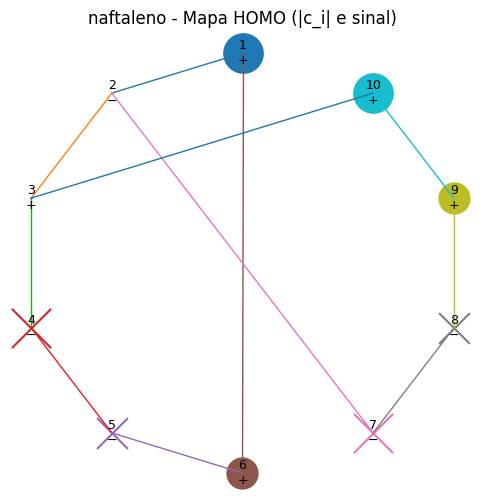

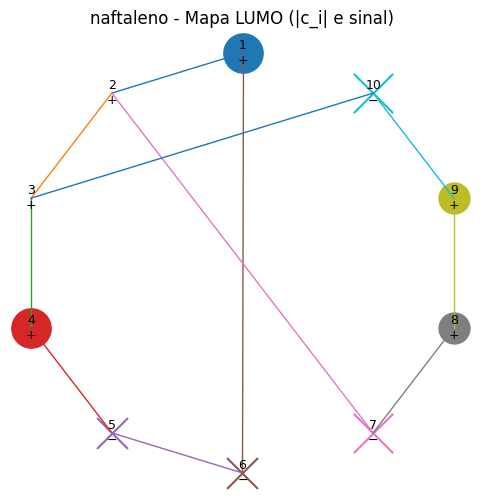


Sistema: quinolina
Parâmetros: α_C=0.0, α_N=0.5, β=-1.0
Átomos N (1..10): [7]
Energias (autovalores) [unid. de β]:
[-2.267026 -1.593263 -1.231569 -1.       -0.527097  0.703283  1.
  1.38422   1.668928  2.362525]
HOMO idx=5, E_HOMO=-0.527097 | LUMO idx=6, E_LUMO=0.703283 | Egap=1.230380
Populações q_i salvas em: huckel_output/q_quinolina.csv
Ordens de ligação p_ij salvas em: huckel_output/pij_quinolina.csv
Coeficientes HOMO/LUMO salvos em: huckel_output/orbs_quinolina.csv


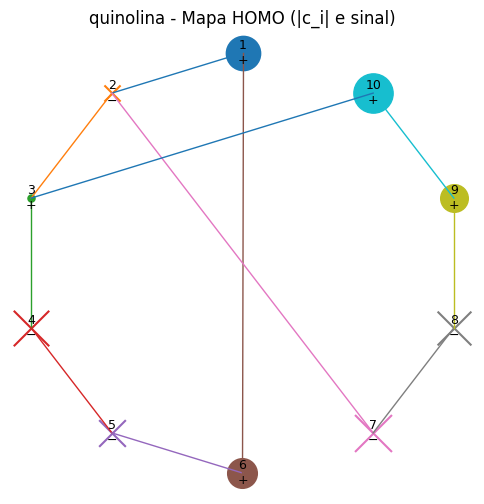

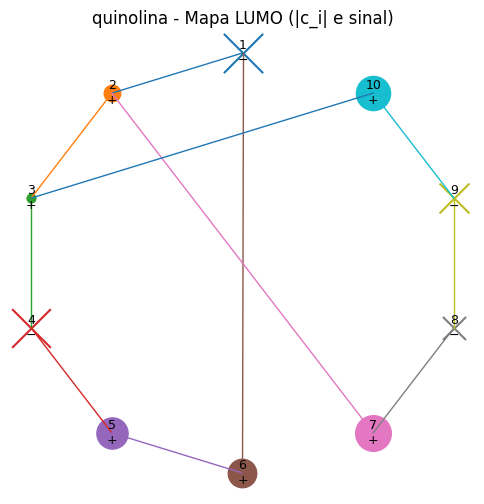


Sistema: diaza(7,9)
Parâmetros: α_C=0.0, α_N=0.5, β=-1.0
Átomos N (1..10): [7, 9]
Energias (autovalores) [unid. de β]:
[-2.247411 -1.507386 -1.229406 -0.916839 -0.494949  0.732344  1.078491
  1.43594   1.75016   2.399056]
HOMO idx=5, E_HOMO=-0.494949 | LUMO idx=6, E_LUMO=0.732344 | Egap=1.227294
Populações q_i salvas em: huckel_output/q_diaza(7,9).csv
Ordens de ligação p_ij salvas em: huckel_output/pij_diaza(7,9).csv
Coeficientes HOMO/LUMO salvos em: huckel_output/orbs_diaza(7,9).csv


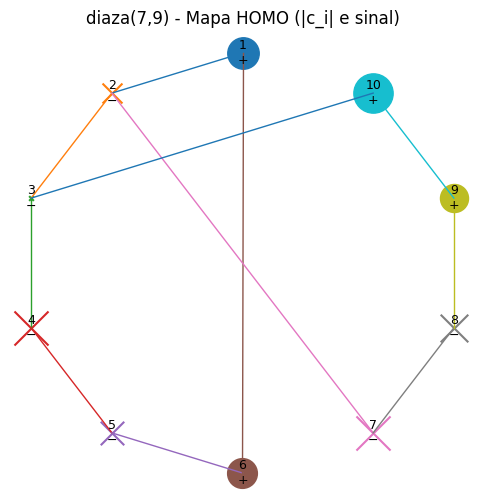

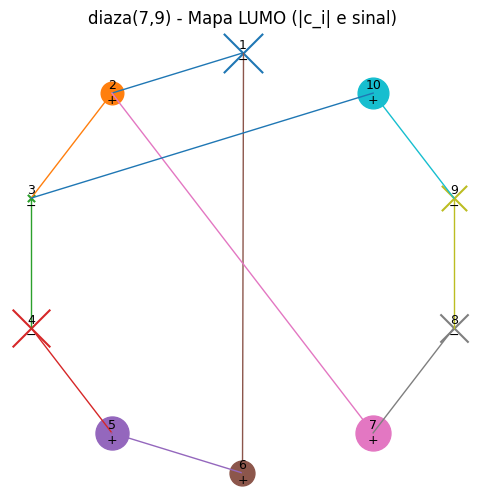


Resumo salvo em: huckel_output/summary_homo_lumo_gap.csv
Arquivos gerados na pasta: huckel_output
 - q_<sistema>.csv  (populações)
 - pij_<sistema>.csv (ordens de ligação)
 - orbs_<sistema>.csv (coeficientes HOMO/LUMO)
 - <sistema>_HOMO.png, <sistema>_LUMO.png (mapas)


In [2]:
# huckel_analysis.py
"""
Análise Hückel (Naftaleno, Quinolina, Diaza escolhida)
- Monta matriz H (α_C, α_N, β)
- Diagonaliza (autovalores, autovetores)
- Calcula populações q_i, ordens de ligação p_ij
- Identifica HOMO, LUMO e gap
- Desenha mapas HOMO/LUMO (|c_i| e sinal) e salva CSVs
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import cos, sin, pi
import os

# -----------------------
# Parâmetros (unidades de |β|)
# -----------------------
alpha_C = 0.0          # α para carbono (referência)
alpha_N_shift = 0.5    # α_N = α_C + alpha_N_shift (ajuste para N piridínico)
beta = -1.0            # β (negativo; aqui usamos -1 para trabalhar em unidades de |β|)

# -----------------------
# Numeração / conectividade (1..10)
# Base: naftaleno com fusão via 2-3
# Arestas definidas em 1-based para facilitar leitura
# -----------------------
edges_1based = [
    (1,2),(2,3),(3,4),(4,5),(5,6),(6,1),  # primeiro anel
    (2,7),(7,8),(8,9),(9,10),(10,3)      # segundo anel
]
N_sites = 10

# -----------------------
# Layout circular (apenas para visualização)
# -----------------------
def circle_layout(n, radius=1.0, phase=pi/2):
    coords = {}
    for i in range(n):
        theta = phase + 2*pi*i/n
        coords[i] = (radius*cos(theta), radius*sin(theta))
    return coords

pos = circle_layout(N_sites)

# -----------------------
# Função que constrói H a partir da lista de tipos de átomo (len=10)
# atom_types: list com 'C' ou 'N' por sítio (0-based)
# -----------------------
def build_system(atom_types):
    H = np.zeros((N_sites, N_sites), dtype=float)
    # diagonais
    for i in range(N_sites):
        if atom_types[i] == 'C':
            H[i,i] = alpha_C
        else:
            H[i,i] = alpha_C + alpha_N_shift
    # off-diagonal: β para ligações
    bonds0 = []
    for i,j in edges_1based:
        i0, j0 = i-1, j-1
        H[i0, j0] = beta
        H[j0, i0] = beta
        bonds0.append((i0, j0))
    return H, bonds0

# -----------------------
# Rotina de diagonalização
# -----------------------
def diagonalize(H):
    E, C = np.linalg.eigh(H)  # energias em ordem ascendente
    return E, C

# -----------------------
# Contagem de elétrons π: aqui 1 elétron por sítio (regra do enunciado)
# -----------------------
def electron_count(atom_types):
    return len(atom_types)

# -----------------------
# Populações q_i
# n_elec assumed even; occ_orbs = n_elec//2; n_mu = 2 for each occupied MO
# -----------------------
def populations_q(C, n_elec):
    occ_orbs = n_elec // 2
    q = np.zeros(C.shape[0])
    for m in range(occ_orbs):
        q += 2.0 * (C[:, m]**2)
    return q

# -----------------------
# Ordens de ligação p_ij para cada par ligado
# p_ij = sum_{ocupados} n_mu * c_{i,mu} * c_{j,mu}  (n_mu = 2)
# -----------------------
def bond_orders_pij(C, bonds, n_elec):
    occ_orbs = n_elec // 2
    pij = {}
    for (i,j) in bonds:
        s = 0.0
        for m in range(occ_orbs):
            s += 2.0 * C[i,m] * C[j,m]
        pij[(i,j)] = s
    return pij

# -----------------------
# HOMO/LUMO helpers
# -----------------------
def homo_lumo(E):
    homo = N_sites//2 - 1
    lumo = homo + 1
    return homo, lumo, E[homo], E[lumo], E[lumo] - E[homo]

# -----------------------
# Plotagem dos mapas de orbital (|c_i| -> tamanho, sinal -> marcador)
# -----------------------
def plot_orbital_map(vec, title, savepath=None):
    mags = np.abs(vec)
    # evitar divisão por zero
    if mags.max() == 0:
        sizes = 100 * np.ones_like(mags)
    else:
        sizes = 800 * (mags / mags.max())
    plt.figure(figsize=(6,6))
    # desenha ligações
    for (a,b) in edges_1based:
        i,j = a-1, b-1
        xi, yi = pos[i]
        xj, yj = pos[j]
        plt.plot([xi, xj], [yi, yj], linewidth=1)
    # desenha nós com sinal
    for i in range(N_sites):
        x, y = pos[i]
        sign = '+' if vec[i] >= 0 else '−'
        marker = 'o' if vec[i] >= 0 else 'x'
        plt.scatter([x], [y], s=sizes[i], marker=marker)
        plt.text(x, y, f"{i+1}\n{sign}", ha='center', va='center', fontsize=9)
    plt.title(title)
    plt.axis('off')
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=200)
    plt.show()
    plt.close()

# -----------------------
# Sistemas definidos (mesma numeração 1..10)
# - Naftaleno: todos C
# - Quinolina: N em sítio 7 (escolha arbitrária compatível com enunciado)
# - Diaza: N em 7 e 9 (exemplo tipo quinoxalina)
# -----------------------
systems = {
    "naftaleno": ['C']*10,
    "quinolina": ['C','C','C','C','C','C','N','C','C','C'],
    "diaza(7,9)": ['C','C','C','C','C','C','N','C','N','C'],
}

# Cria pasta de saída
outdir = "huckel_output"
os.makedirs(outdir, exist_ok=True)

# -----------------------
# Loop por sistema: calculos, tabelas, plots, arquivos
# -----------------------
summary_rows = []
for name, types in systems.items():
    print("\n" + "="*70)
    print(f"Sistema: {name}")
    print("="*70)
    H, bonds = build_system(types)
    E, C = diagonalize(H)
    n_elec = electron_count(types)
    q = populations_q(C, n_elec)
    pij = bond_orders_pij(C, bonds, n_elec)
    homo_idx, lumo_idx, Eh, El, Eg = homo_lumo(E)

    print(f"Parâmetros: α_C={alpha_C}, α_N={alpha_C+alpha_N_shift}, β={beta}")
    print("Átomos N (1..10):", [i+1 for i,t in enumerate(types) if t == 'N'])
    print("Energias (autovalores) [unid. de β]:")
    print(np.round(E, 6))
    print(f"HOMO idx={homo_idx+1}, E_HOMO={Eh:.6f} | LUMO idx={lumo_idx+1}, E_LUMO={El:.6f} | Egap={Eg:.6f}")

    # DataFrame para q_i
    df_q = pd.DataFrame({
        "site": np.arange(1, N_sites+1),
        "atom": types,
        "q_i": np.round(q, 6)
    }).set_index("site")
    q_csv = os.path.join(outdir, f"q_{name}.csv")
    df_q.to_csv(q_csv)
    print(f"Populações q_i salvas em: {q_csv}")

    # DataFrame para p_ij
    rows = []
    for (i,j), val in pij.items():
        rows.append({"bond(i-j)": f"{i+1}-{j+1}", "p_ij": round(val, 6)})
    df_p = pd.DataFrame(rows).sort_values("bond(i-j)").reset_index(drop=True)
    p_csv = os.path.join(outdir, f"pij_{name}.csv")
    df_p.to_csv(p_csv, index=False)
    print(f"Ordens de ligação p_ij salvas em: {p_csv}")

    # Salva vetor HOMO e LUMO em CSVs
    df_orbs = pd.DataFrame({
        "site": np.arange(1, N_sites+1),
        "c_HOMO": np.round(C[:, homo_idx], 8),
        "c_LUMO": np.round(C[:, lumo_idx], 8),
        "abs_c_HOMO": np.round(np.abs(C[:, homo_idx]), 8),
        "abs_c_LUMO": np.round(np.abs(C[:, lumo_idx]), 8),
    }).set_index("site")
    orb_csv = os.path.join(outdir, f"orbs_{name}.csv")
    df_orbs.to_csv(orb_csv)
    print(f"Coeficientes HOMO/LUMO salvos em: {orb_csv}")

    # Plots
    plot_orbital_map(C[:, homo_idx], f"{name} - Mapa HOMO (|c_i| e sinal)",
                     savepath=os.path.join(outdir, f"{name}_HOMO.png"))
    plot_orbital_map(C[:, lumo_idx], f"{name} - Mapa LUMO (|c_i| e sinal)",
                     savepath=os.path.join(outdir, f"{name}_LUMO.png"))

    summary_rows.append({
        "sistema": name,
        "N_sites": N_sites,
        "N_elec": n_elec,
        "E_HOMO": round(Eh,6),
        "E_LUMO": round(El,6),
        "Egap": round(Eg,6)
    })

# resumo final
df_summary = pd.DataFrame(summary_rows)
summary_csv = os.path.join(outdir, "summary_homo_lumo_gap.csv")
df_summary.to_csv(summary_csv, index=False)
print("\nResumo salvo em:", summary_csv)
print("Arquivos gerados na pasta:", outdir)
print(" - q_<sistema>.csv  (populações)")
print(" - pij_<sistema>.csv (ordens de ligação)")
print(" - orbs_<sistema>.csv (coeficientes HOMO/LUMO)")
print(" - <sistema>_HOMO.png, <sistema>_LUMO.png (mapas)")
